# Prueba Tecnica Data Scientist/ Bnamericas

**postulante: Israel Aguirre Villa**

Sobre mi interpretacion de "sesion" al leer los requerimientos : 

1) La primera actividad de un dia cuenta como una sesion.

2) Si el usuario durante una sesion lleva conectado durante un tiempo, habra una nueva sesion cuando supere
   las 2 horas de actividades, por ejemplo, primera actividad a las 9:20 (primera sesion), segunda actividad a las 10:20, 
   tercerca actividad a las 11:21 (segunda sesion del dia).
   
3) Si el usuario incia una actividad con una diferencia de mas de 2 horas respecto a la ultima,
   es una nueva sesion.
4) Salvo los casos anteriores, no hay otra forma que el usuario cree una nueva sesion.

# Restaurando la base de datos y generando el csv

En primer lugar para restaurar la base de datos, se crea una nueva base de datos en este caso "bn". Se abre cmd y se accede al directorio bin de postgres y se ejecuta el siguiente comando: 

pg_restore.exe --host "localhost" --port "5432" --username "postgres" -O --role "postgres" --dbname "bn" --verbose "C:\\PROGRA~1\\POSTGR~1\\12\\bin\\testdb.bak"

Una vez restaurado el db, se hacen la consulta sql para extraer los datos en csv:


select 

activity.id as activity_id,

activity.user_id,

u.company_id,

activity.type,

activity.timestamp,

u.mail,

u.age,

company.name,

company.segment

from activity

join "user" u on activity.user_id= u.id

join company on u.company_id= company.id


# Trabajando el csv en python para generar el reporte

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

**Leamos los datos, revisemos si hay NaNs y veamos de que tipo son**

In [2]:
bn=pd.read_csv("C:/Users/hp/OneDrive - Universidad Técnica Federico Santa María/Escritorio/BN.csv")
bn.isnull().sum()

activity_id    0
user_id        0
company_id     0
type           0
timestamp      0
mail           0
age            0
name           0
segment        0
dtype: int64

In [3]:
bn.dtypes

activity_id     int64
user_id         int64
company_id      int64
type           object
timestamp      object
mail           object
age             int64
name           object
segment        object
dtype: object

**Puesto que timestamp es una fecha con hora, convirtamos esta columna a tipo datetime de python**

In [4]:
bn["timestamp"]=pd.to_datetime(bn["timestamp"], dayfirst=True)

In [6]:
bn.head(10)

,activity_id,user_id,company_id,type,timestamp,mail,age,name,segment
0,0,0,0,dashboard,2020-01-01 09:10:00,krodriquez@yahoo.com,38,Despacho Amaya y Castro,technology
1,1,0,0,search,2020-01-01 09:11:00,krodriquez@yahoo.com,38,Despacho Amaya y Castro,technology
2,2,0,0,email,2020-01-01 09:41:00,krodriquez@yahoo.com,38,Despacho Amaya y Castro,technology
3,3,0,0,email,2020-01-01 15:24:00,krodriquez@yahoo.com,38,Despacho Amaya y Castro,technology
4,4,0,0,email,2020-01-01 15:40:00,krodriquez@yahoo.com,38,Despacho Amaya y Castro,technology
5,5,0,0,dashboard,2020-01-02 09:51:00,krodriquez@yahoo.com,38,Despacho Amaya y Castro,technology
6,6,0,0,email,2020-01-02 10:07:00,krodriquez@yahoo.com,38,Despacho Amaya y Castro,technology
7,7,0,0,data,2020-01-02 10:52:00,krodriquez@yahoo.com,38,Despacho Amaya y Castro,technology
8,8,0,0,dashboard,2020-01-02 10:56:00,krodriquez@yahoo.com,38,Despacho Amaya y Castro,technology
9,9,0,0,search,2020-01-02 11:05:00,krodriquez@yahoo.com,38,Despacho Amaya y Castro,technology


In [7]:
bn.nunique()

activity_id    1000263
user_id           2095
company_id         100
type                 4
timestamp        39619
mail              2094
age                 61
name               100
segment              7
dtype: int64

**Puesto que se solicita tener un contador del tipo de actividades, veamos cuales son las actividades unicas que hay**

In [8]:
bn["type"].unique()

array(['dashboard', 'search', 'email', 'data'], dtype=object)

In [9]:
#creamos nuevas columnas que contengan la fecha (formato datetime), la hora y los minutos
bn["minuto"]=bn["timestamp"].dt.minute
bn["hora"]=bn["timestamp"].dt.hour
bn["fecha"]=bn["timestamp"].dt.date

In [10]:
#creamos un nuevo DataFrame donde se guardara la actividad diaria del usuario
d={"fecha":bn["fecha"], "hora":bn["hora"], "minuto": bn["minuto"], "user_id":bn["user_id"], 
   "segment":bn["segment"], "name":bn["name"]}

nuevobn=pd.DataFrame(d)

nuevobn["sesiones"]=0
nuevobn["dashboard"]=0
nuevobn["search"]=0
nuevobn["email"]=0
nuevobn["data"]=0
nuevobn["actividades_hoy"]=0

nuevobn.head(5)

,fecha,hora,minuto,user_id,segment,name,sesiones,dashboard,search,email,data,actividades_hoy
0,2020-01-01,9,10,0,technology,Despacho Amaya y Castro,0,0,0,0,0,0
1,2020-01-01,9,11,0,technology,Despacho Amaya y Castro,0,0,0,0,0,0
2,2020-01-01,9,41,0,technology,Despacho Amaya y Castro,0,0,0,0,0,0
3,2020-01-01,15,24,0,technology,Despacho Amaya y Castro,0,0,0,0,0,0
4,2020-01-01,15,40,0,technology,Despacho Amaya y Castro,0,0,0,0,0,0


## Creando un resporte de actividades con la informacion de actividades por cada usuario

**Lo que creare aqui, sera un DataFrame a través de un ciclo for que va recorriendo las actividades y añadiendo el numero de sesiones a lo largo de un dia, de forma que la ultima actividad del dia, tendra el conteo de las sesiones de ese dia. Al cambiar de dia, este contador sera restablecido a 0.**
  
  **De igual forma, se añade un contadorpor tipo de actividad y las actividades totales en el dia. La ultima 
  actividad del dia tendra la suma por tipo de actividad y actividades total del dia. al cambiar de dia, este 
  este contador sera restablecido a 0**
  
  **Finalmente, de acuerdo a lo solicitado, seran borrados los indices que contienen una fecha repetida y 
  solo se dejara la ultima actividad de usuario (que contiene la informacion de sesiones, actividades totales y
  conteo por tipo de actividad**

In [15]:
for actividad in range(len(bn)): 
    
    #definimos nuestros contadores para la primera iteracion
    if actividad==0:
        sesiones_hoy=1
        dashboard_hoy=0
        search_hoy=0
        email_hoy=0
        data_hoy=0
        actividades_hoy=0
        instante_inicio_de_sesion=bn["hora"][0]+bn["minuto"][0]/60
        
        if bn.at[actividad,"type"]=="dashboard":
            dashboard_hoy+=1
        elif bn.at[actividad,"type"]=="search":
            search_hoy+=1
        elif bn.at[actividad,"type"]=="email":
            email_hoy+=1
        elif bn.at[actividad,"type"]=="data":
            data_hoy+=1
            
        #guardamos en el DataFrame los valores para la primera iteracion 
        nuevobn.at[actividad,"sesiones"]=sesiones_hoy
        nuevobn.at[actividad,"dashboard"]=dashboard_hoy
        nuevobn.at[actividad,"search"]=search_hoy
        nuevobn.at[actividad,"email"]=email_hoy
        nuevobn.at[actividad,"data"]=data_hoy
        nuevobn.at[actividad,"user_id"]=bn.at[actividad,"user_id"]
        nuevobn.at[actividad,"actividades_hoy"]=dashboard_hoy+search_hoy+email_hoy+data_hoy
        continue
        
    #cuantificamos el tiempo entre cada actividad 
    tiempo2=bn["hora"][actividad]+bn["minuto"][actividad]/60
    tiempo1=bn["hora"][actividad-1]+bn["minuto"][actividad-1]/60
        
    # si la fecha es la misma, a priori no hay nueva sesion, a menos que se cumplan las condiciones establecidas de tiempo
    if bn["fecha"][actividad]==bn["fecha"][actividad-1]:
        
        #si el tiempo de la la actividad tiene 2 horas de diferencias con la ultima, hay nueva sesion.
        if tiempo2-tiempo1>2:
            sesiones_hoy+=1
            instante_inicio_de_sesion=tiempo2 #definimos nuestra referencia de inicio de sesion
        
        # si el tiempo actual supera por 2 horas el tiempo de inicio de la sesion actual, hay nueva sesion.
        elif tiempo2-instante_inicio_de_sesion>2:
            sesiones_hoy+=1
            instante_inicio_de_sesion=tiempo2
            
    #si la fecha actual es diferente a la anterior, entonces es un nuevo dia, por lo que hay nueva sesion.     
    else:
        sesiones_hoy=1
        instante_inicio_de_sesion=tiempo2
        dashboard_hoy=0
        search_hoy=0
        email_hoy=0
        data_hoy=0
        actividades_hoy=0
        
    #Guardamos el tipo de actividad
    if bn.at[actividad,"type"]=="dashboard":
        dashboard_hoy+=1
    elif bn.at[actividad,"type"]=="search":
        search_hoy+=1
    elif bn.at[actividad,"type"]=="email":
        email_hoy+=1
    elif bn.at[actividad,"type"]=="data":
        data_hoy+=1
    
    #escribimos en el DataFrame los valores actualizados de esta actividad o iteracion
    nuevobn.at[actividad,"sesiones"]=sesiones_hoy
    nuevobn.at[actividad,"dashboard"]=dashboard_hoy
    nuevobn.at[actividad,"search"]=search_hoy
    nuevobn.at[actividad,"email"]=email_hoy
    nuevobn.at[actividad,"data"]=data_hoy
    nuevobn.at[actividad,"actividades_hoy"]=dashboard_hoy+search_hoy+email_hoy+data_hoy
    nuevobn.at[actividad,"user_id"]=bn.at[actividad,"user_id"]
    
nuevobn

,fecha,hora,minuto,user_id,segment,name,sesiones,dashboard,search,email,data,actividades_hoy
0,2020-01-01,9,10,0,technology,Despacho Amaya y Castro,1,1,0,0,0,1
1,2020-01-01,9,11,0,technology,Despacho Amaya y Castro,1,1,1,0,0,2
2,2020-01-01,9,41,0,technology,Despacho Amaya y Castro,1,1,1,1,0,3
3,2020-01-01,15,24,0,technology,Despacho Amaya y Castro,2,1,1,2,0,4
4,2020-01-01,15,40,0,technology,Despacho Amaya y Castro,2,1,1,3,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1000258,2020-03-31,9,56,2094,mining,Monroy-Cardona A.C.,1,1,1,1,4,7
1000259,2020-03-31,9,59,2094,mining,Monroy-Cardona A.C.,1,1,1,2,4,8
1000260,2020-03-31,11,0,2094,mining,Monroy-Cardona A.C.,2,1,2,2,4,9
1000261,2020-03-31,11,1,2094,mining,Monroy-Cardona A.C.,2,1,2,3,4,10


## Obtenemos el reporte diario de los usuarios

**El DataFrame ya tiene forma, solo queda guardar la ultima actividad del dia y eliminar el resto**

**Podriamos usar el metodo DataFrame.drop() pero esto requiere un ciclo for para guardar la variable
  de fecha y preguntar si la de la iteracion actual es o no igual a la anterior, pero esto tiene un alto
  valor computacional y es mas optimo llamar las filas que queremos del dataframe con un array**

In [16]:
df=nuevobn[nuevobn["fecha"]!=nuevobn["fecha"].shift(-1)]
df

,fecha,hora,minuto,user_id,segment,name,sesiones,dashboard,search,email,data,actividades_hoy
4,2020-01-01,15,40,0,technology,Despacho Amaya y Castro,2,1,1,3,0,5
14,2020-01-02,18,8,0,technology,Despacho Amaya y Castro,3,2,1,4,3,10
15,2020-01-04,11,18,0,technology,Despacho Amaya y Castro,1,0,1,0,0,1
24,2020-01-05,19,1,0,technology,Despacho Amaya y Castro,4,1,3,2,3,9
28,2020-01-07,15,43,0,technology,Despacho Amaya y Castro,2,2,1,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1000239,2020-03-26,10,45,2094,mining,Monroy-Cardona A.C.,1,2,0,2,0,4
1000240,2020-03-27,10,47,2094,mining,Monroy-Cardona A.C.,1,0,1,0,0,1
1000246,2020-03-29,18,19,2094,mining,Monroy-Cardona A.C.,3,2,2,1,1,6
1000251,2020-03-30,17,22,2094,mining,Monroy-Cardona A.C.,3,1,2,2,0,5


**Finalmente eliminamos la columna de hora y minutos que no tiene mucho que aportar**

In [17]:
reporte=df.drop(columns=["hora","minuto"])


#cambiamos el indice del dataframe con orden de 
reporte.index=pd.Series((range(len(reporte))))
reporte

,fecha,user_id,segment,name,sesiones,dashboard,search,email,data,actividades_hoy
0,2020-01-01,0,technology,Despacho Amaya y Castro,2,1,1,3,0,5
1,2020-01-02,0,technology,Despacho Amaya y Castro,3,2,1,4,3,10
2,2020-01-04,0,technology,Despacho Amaya y Castro,1,0,1,0,0,1
3,2020-01-05,0,technology,Despacho Amaya y Castro,4,1,3,2,3,9
4,2020-01-07,0,technology,Despacho Amaya y Castro,2,2,1,0,1,4
...,...,...,...,...,...,...,...,...,...,...
147992,2020-03-26,2094,mining,Monroy-Cardona A.C.,1,2,0,2,0,4
147993,2020-03-27,2094,mining,Monroy-Cardona A.C.,1,0,1,0,0,1
147994,2020-03-29,2094,mining,Monroy-Cardona A.C.,3,2,2,1,1,6
147995,2020-03-30,2094,mining,Monroy-Cardona A.C.,3,1,2,2,0,5


En la descripcion de la prueba tecnica, se detallo que el reporte debe ser capaz se resumir la actividad por compañia 
y tipo de compañia. Generemos un reporte que nos de una idea el comportamiento de las compañia y el tipo.

In [18]:
#generamos los pesos del grafico de barras (frecuencia)
pesos_actividades=list()
pesos_sesiones=list()

for segmento in reporte["segment"].unique():
    pesos_actividades.append(reporte[reporte["segment"]==segmento].actividades_hoy.sum())
    pesos_sesiones.append(reporte[reporte["segment"]==segmento].sesiones.sum())

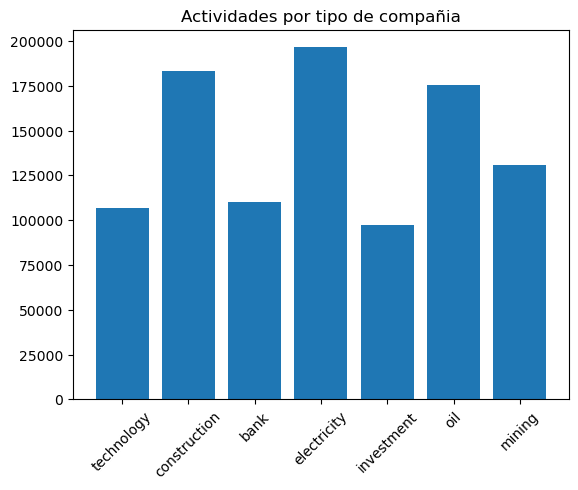

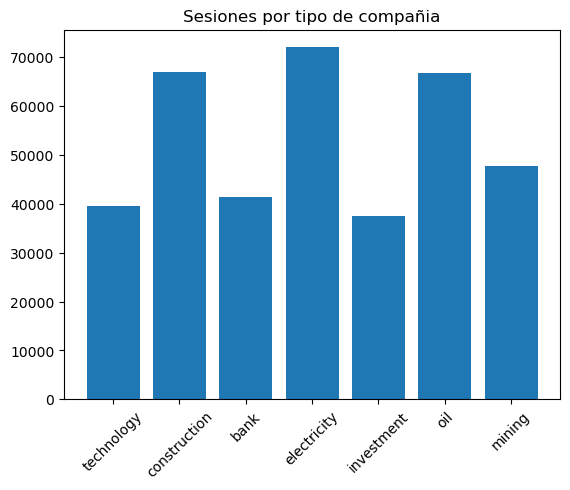

In [19]:
#generamos los graficos de actividades y sesiones
plt.title("Actividades por tipo de compañia")
plt.bar(reporte["segment"].unique(), pesos_actividades)
plt.xticks(rotation=45)
plt.show()

plt.title("Sesiones por tipo de compañia")
plt.bar(reporte["segment"].unique(), pesos_sesiones)
plt.xticks(rotation=45)
plt.show()

# Implementación del modelo de clasificación

## Analisis del comportamiento de los usuarios

Para la implementación del modelo vamos resumir las actividades diarias en cada usuario en diferentes atributos,
  de forma que cada usuario solo tenga una fila del dataframe

¿Como haremos esto?

Puesto que los que nos interesa es el comportamiento del usuario para determinar si se encuentra en cierto rango
de actividad, haremos un resumen de su actividad a lo largo de **enero a marzo 2020**, de forma de agregar atributos
que sean **capaces** de resumir su actividad en este periodo. Los cuales se eligiran:

1) Sesiones totales en el periodo.

2) Actividades totales en el periodo.

3) Dias totales de **NO** actividad en la plataforma.

4) Tipo de actividad total en la plataforma (dashboard, email, search y data)  

In [20]:
#creamos un nuevo dataframe vacio para generar el nuevo reporte que contiene el resumen de actividades del usuario.
nuevo_reporte=pd.DataFrame({})

#Recorremos el reporte por user_id
for usuario in reporte["user_id"].unique(): 
    reporte_de_usuario=reporte[reporte["user_id"]==usuario] #filtramos el dataframe solo con los registros del usuario
    dimension_dia=datetime.timedelta(days=1) #asignamos la variable tipo datetime de 1 dia
    
    #calculamos los dias de inactividad por cada usuario
    dias_inactividad=(((reporte_de_usuario["fecha"]-reporte_de_usuario["fecha"].shift(+1))
         [1:len(reporte_de_usuario)]-dimension_dia)/dimension_dia).sum()
    
    #calculamos el resto de variables
    sesiones_totales=reporte_de_usuario["sesiones"].sum()
    actividades_totales=reporte_de_usuario["actividades_hoy"].sum()
    dashboard_totales= reporte_de_usuario["dashboard"].sum()
    search_totales= reporte_de_usuario["search"].sum()
    email_totales= reporte_de_usuario["email"].sum()
    data_totales= reporte_de_usuario["data"].sum()
    
    #escribimos en el dataframe los valores calculados del reporte
    nuevo_reporte.at[usuario,"user_id"]=usuario
    nuevo_reporte.at[usuario,"segment"]=reporte[reporte["user_id"]==usuario].iloc[0,2]
    nuevo_reporte.at[usuario,"dias_inactividad"]=dias_inactividad
    nuevo_reporte.at[usuario,"sesiones_totales"]=sesiones_totales
    nuevo_reporte.at[usuario,"actividades_totales"]=actividades_totales
    nuevo_reporte.at[usuario,"dashboard_totales"]=dashboard_totales
    nuevo_reporte.at[usuario,"search_totales"]=search_totales
    nuevo_reporte.at[usuario,"email_totales"]=email_totales
    nuevo_reporte.at[usuario,"data_totales"]=data_totales
    
nuevo_reporte

,user_id,segment,dias_inactividad,sesiones_totales,actividades_totales,dashboard_totales,search_totales,email_totales,data_totales
0,0.0,technology,33.0,108.0,234.0,63.0,47.0,68.0,56.0
1,1.0,technology,2.0,280.0,874.0,221.0,239.0,195.0,219.0
2,2.0,technology,18.0,160.0,333.0,93.0,89.0,78.0,73.0
3,3.0,technology,4.0,248.0,705.0,165.0,191.0,177.0,172.0
4,4.0,technology,47.0,69.0,128.0,33.0,37.0,24.0,34.0
...,...,...,...,...,...,...,...,...,...
2090,2090.0,mining,3.0,259.0,720.0,181.0,179.0,180.0,180.0
2091,2091.0,mining,1.0,277.0,918.0,237.0,210.0,245.0,226.0
2092,2092.0,mining,0.0,291.0,958.0,231.0,264.0,248.0,215.0
2093,2093.0,mining,2.0,253.0,814.0,203.0,201.0,209.0,201.0


## Analisis exploratorio (EDA)

ya que tenemos todas las variables que son capaces de representar el comportamiento de actividad por cada usuario en el
periodo enero-marzo 2020, veamos como se distribuyen las variables para entenderlas un poco mejor.

In [21]:
#generamos 8 graficos en 2 filas, para los atributos que calculamos anteriormente
fig, ax = plt.subplots(nrows=2,ncols=4,figsize = (25,10),dpi=800)
fig.tight_layout()

for i in range(2,9):
    #establecemos algunos parametros estadisticos del comportamiento
    min_val = nuevo_reporte.iloc[:,i].min()
    max_val = nuevo_reporte.iloc[:,i].max()
    media_val = nuevo_reporte.iloc[:,i].mean()
    mediana_val = nuevo_reporte.iloc[:,i].median()
    moda_val = nuevo_reporte.iloc[:,i].mode()[0]
    
    #generamos los graficos
    ax[(i-1)//4][(i-1)%4].hist(x=nuevo_reporte.iloc[:,i], bins=80)
    ax[(i-1)//4][(i-1)%4].set_title(nuevo_reporte.columns[i])
    ax[(i-1)//4][(i-1)%4].grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
    
    #generamos las lineas verticales de los parametros estadiscticos
    ax[(i-1)//4][(i-1)%4].axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2,label="minimo")
    ax[(i-1)//4][(i-1)%4].axvline(x=media_val, color = 'cyan', linestyle='dashed', linewidth = 2, label="media")
    ax[(i-1)//4][(i-1)%4].axvline(x=mediana_val, color = 'red', linestyle='dashed', linewidth = 2,label="mediana")
    ax[(i-1)//4][(i-1)%4].axvline(x=moda_val, color = 'yellow', linestyle='dashed', linewidth = 2, label="moda")
    ax[(i-1)//4][(i-1)%4].axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2, label="maximo")
    ax[(i-1)//4][(i-1)%4].legend()
    
    
fig.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

In [22]:
#generamos 8 graficos en 2 filas, para los atributos que calculamos anteriormente
fig, ax = plt.subplots(nrows=2,ncols=4,figsize = (25,10),dpi=800)
fig.tight_layout()

for i in range(2,9):
    
    #generamos los graficos
    ax[(i-1)//4][(i-1)%4].boxplot(nuevo_reporte.iloc[:,i])
    ax[(i-1)//4][(i-1)%4].set_title(nuevo_reporte.columns[i])
    
    
fig.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

Veamos la relacion lineal entre las variables con la matriz de correlacion. puesto que utilizaremos un modelo lineal para
la prediccion, nos interesa calcular que variables tienen una relacion lineal con las otras, por este motivo, usaremos el
indicador de **pearson**

In [23]:
matriz_corr = nuevo_reporte.corr(method='pearson')
matriz_corr.style.background_gradient(cmap='coolwarm')

,user_id,dias_inactividad,sesiones_totales,actividades_totales,dashboard_totales,search_totales,email_totales,data_totales
user_id,1.000000,-0.031353,0.027675,0.023807,0.019214,0.025073,0.026731,0.023287
dias_inactividad,-0.031353,1.000000,-0.959579,-0.897134,-0.889782,-0.885884,-0.889889,-0.889078
sesiones_totales,0.027675,-0.959579,1.000000,0.978662,0.970420,0.967903,0.969853,0.969488
actividades_totales,0.023807,-0.897134,0.978662,1.000000,0.990959,0.989976,0.990595,0.990674
dashboard_totales,0.019214,-0.889782,0.970420,0.990959,1.000000,0.974595,0.975784,0.976140
search_totales,0.025073,-0.885884,0.967903,0.989976,0.974595,1.000000,0.974021,0.973852
email_totales,0.026731,-0.889889,0.969853,0.990595,0.975784,0.974021,1.000000,0.975140
data_totales,0.023287,-0.889078,0.969488,0.990674,0.976140,0.973852,0.975140,1.000000


Las correlaciones entre todas las variables menos dias_inactividad tiene una correlacion lineal muy muy fuerte (casi perfecta)
por lo que podriamos elegir solo una ya que las otras no tienen mucho que aportar en terminos del modelo y asi evitamos
el fenomeno de colinealidad y un gasto computacional innecesario, por lo que nos quedaremos con **dias_inactividad**
y **actividades_totales**.

Por otro lado, podemos incorporar la variable dummy tipo de compañia con **one hot encoding**

In [24]:
nuevo_reporte.drop(["sesiones_totales","dashboard_totales","search_totales","email_totales","data_totales"],axis=1,inplace=True)

# Modelado del modelo de clasificación

Cargamos los datos etiquetados como activo y no activo.

In [25]:
etiquetados=pd.read_csv("C:/Users/hp/OneDrive - Universidad Técnica Federico Santa María/Escritorio/U/prueba tecnica BNamericas/users.csv")   
etiquetados

,user_id,class
0,21,ACTIVE
1,23,ACTIVE
2,28,ACTIVE
3,33,ACTIVE
4,37,NON-ACTIVE
...,...,...
195,2082,ACTIVE
196,2084,ACTIVE
197,2087,ACTIVE
198,2088,ACTIVE


hacemos un merge de los datos etiquetados con los valores del reporte

In [26]:
etiquetados=etiquetados.merge(nuevo_reporte, on=['user_id'], how="left")
etiquetados

,user_id,class,segment,dias_inactividad,actividades_totales
0,21,ACTIVE,construction,6.0,655.0
1,23,ACTIVE,construction,9.0,521.0
2,28,ACTIVE,construction,0.0,1010.0
3,33,ACTIVE,construction,1.0,783.0
4,37,NON-ACTIVE,bank,40.0,185.0
...,...,...,...,...,...
195,2082,ACTIVE,mining,0.0,1240.0
196,2084,ACTIVE,mining,0.0,963.0
197,2087,ACTIVE,mining,17.0,429.0
198,2088,ACTIVE,mining,3.0,653.0


agregamos las variables dummies del segmento de la empresa y eliminamos una columna puesto que estaremos usando un modelo lineal. **Es importante eliminar una columna de las variables dummies para que el coeficiente de posicion (b+aX en este caso b) 
no tenga problemas para ajustarse.**

In [27]:
#creamos las variables dummies con OneHotEncoding y eliminamos una columna
nuevo_reporte=pd.get_dummies(data=nuevo_reporte, columns=["segment"])
nuevo_reporte.drop(["segment_bank"], axis=1, inplace=True)

etiquetados=pd.get_dummies(data=etiquetados, columns=["segment"])
etiquetados.drop(["segment_bank"], axis=1, inplace=True)

In [28]:
etiquetados

,user_id,class,dias_inactividad,actividades_totales,segment_construction,segment_electricity,segment_investment,segment_mining,segment_oil,segment_technology
0,21,ACTIVE,6.0,655.0,1,0,0,0,0,0
1,23,ACTIVE,9.0,521.0,1,0,0,0,0,0
2,28,ACTIVE,0.0,1010.0,1,0,0,0,0,0
3,33,ACTIVE,1.0,783.0,1,0,0,0,0,0
4,37,NON-ACTIVE,40.0,185.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
195,2082,ACTIVE,0.0,1240.0,0,0,0,1,0,0
196,2084,ACTIVE,0.0,963.0,0,0,0,1,0,0
197,2087,ACTIVE,17.0,429.0,0,0,0,1,0,0
198,2088,ACTIVE,3.0,653.0,0,0,0,1,0,0


In [29]:
#Dividimos los datos en entrenemiento y test
X=etiquetados.drop(['class', 'user_id'], axis=1,inplace=False).values
y=etiquetados['class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

#Escalamos los datos
X_train=StandardScaler().fit_transform(X_train)
X_test=StandardScaler().fit_transform(X_test)

## Modelo Lineal: SVC linear

In [30]:
#Definimos el clasificador
clasificador=SVC(kernel="linear",C=1, random_state=1)

#calculamos el score con la metrica F1
scores = cross_val_score(clasificador, X_train, y_train, cv=5, scoring='f1_micro')
scores

array([0.93333333, 0.96666667, 0.96666667, 0.96666667, 0.96666667])

**Ya que tenemos el modelo con validacion cruzada de 5 divisiones, buscamos los mejores hiperparametros**

In [31]:
clasificador=SVC(kernel="linear",C=2, random_state=1)


scores = cross_val_score(clasificador, X_train, y_train, cv=5, scoring='f1_micro')

scores

array([0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96666667])

In [32]:
clasificador=SVC(kernel="linear",C=3, random_state=5)

scores = cross_val_score(clasificador, X_train, y_train, cv=5, scoring='f1_micro')

scores

array([0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96666667])

**Al parecer el optimo del hiperparametro C es 3, que es un parametro de regularizacion**

Ahora evaluemos nuestro conjunto de test:

In [33]:
clasificador.fit(X_train,y_train)
y_pred= clasificador.predict(X_test)

In [34]:
f1_score(y_test, y_pred, average="binary", pos_label="ACTIVE")

0.9777777777777777

**El modelo se comporta baste bien, entregando un Score F1 de 97%. Veamos como esta la matriz de confusion y donde
es que se equivoca mas.**

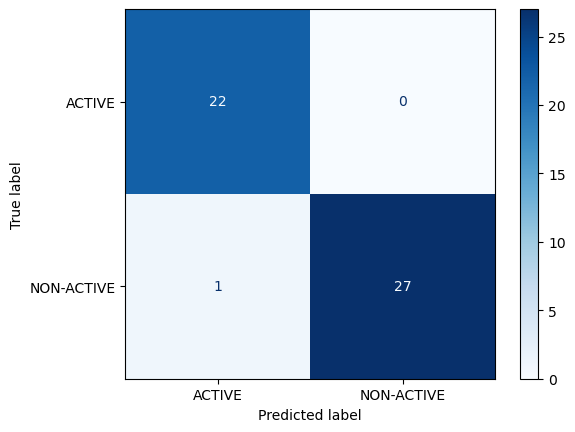

In [35]:
cm = confusion_matrix(y_test, y_pred, labels=clasificador.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clasificador.classes_)
disp.plot(cmap="Blues")
plt.show()

Para esta set de test, tuvo un unico error nuestro clasificador (basado en SVM, un clasificador lineal en el hiperespacio)
al etiquetar un dato que es NON-ACTIVE como ACTIVE. El modelo al parecer entrega muy buenos resultados y con algunos ajustes
y evaluaciones, podria pasar a preduccion.

# Visualizacion de los usuarios Activos-NoActivos durante marzo.

In [126]:
#creamos una columna que contenga los meses numericamente
reporte_marzo=reporte.copy()

reporte_marzo["fecha"]=pd.to_datetime(reporte_marzo["fecha"], dayfirst=True)
reporte_marzo["mes"]=reporte_marzo["fecha"].dt.month

reporte_marzo

,fecha,user_id,segment,name,sesiones,dashboard,search,email,data,actividades_hoy,mes
0,2020-01-01,0,technology,Despacho Amaya y Castro,2,1,1,3,0,5,1
1,2020-01-02,0,technology,Despacho Amaya y Castro,3,2,1,4,3,10,1
2,2020-01-04,0,technology,Despacho Amaya y Castro,1,0,1,0,0,1,1
3,2020-01-05,0,technology,Despacho Amaya y Castro,4,1,3,2,3,9,1
4,2020-01-07,0,technology,Despacho Amaya y Castro,2,2,1,0,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...
147992,2020-03-26,2094,mining,Monroy-Cardona A.C.,1,2,0,2,0,4,3
147993,2020-03-27,2094,mining,Monroy-Cardona A.C.,1,0,1,0,0,1,3
147994,2020-03-29,2094,mining,Monroy-Cardona A.C.,3,2,2,1,1,6,3
147995,2020-03-30,2094,mining,Monroy-Cardona A.C.,3,1,2,2,0,5,3


In [127]:
# nos quedamos unicamente con los meses 3 (marzo)
reporte_marzo=reporte_marzo[reporte_marzo["mes"]==3]

#Ahora que solo tenemos el dataframe con los valores de marzo, hacemos un merge con los datos etiquetados

etiqueta=pd.read_csv("C:/Users/hp/OneDrive - Universidad Técnica Federico Santa María/Escritorio/U/prueba tecnica BNamericas/users.csv") 

etiqueta=etiqueta.merge(reporte_marzo, on=['user_id'], how="left")

In [129]:
#creamos un dataframe reporte_marzo vacio
reporte_marzo=pd.DataFrame({})


#Recorremos el reporte por user_id
for usuario in etiqueta["user_id"].unique(): 
    reporte_de_usuario=etiqueta[etiqueta["user_id"]==usuario] #filtramos el dataframe solo con los registros del usuario
    dimension_dia=datetime.timedelta(days=1) #asignamos la variable tipo datetime de 1 dia
    
    #calculamos los dias de inactividad por cada usuario
    dias_inactividad=(((reporte_de_usuario["fecha"]-reporte_de_usuario["fecha"].shift(+1))
         [1:len(reporte_de_usuario)]-dimension_dia)/dimension_dia).sum()
    
    #calculamos el resto de variables
    sesiones_totales=reporte_de_usuario["sesiones"].sum()
    actividades_totales=reporte_de_usuario["actividades_hoy"].sum()
    dashboard_totales= reporte_de_usuario["dashboard"].sum()
    search_totales= reporte_de_usuario["search"].sum()
    email_totales= reporte_de_usuario["email"].sum()
    data_totales= reporte_de_usuario["data"].sum()
    
    #escribimos en el dataframe los valores calculados del reporte
    reporte_marzo.at[usuario,"user_id"]=usuario
    reporte_marzo.at[usuario,"segment"]=etiqueta[etiqueta["user_id"]==usuario].iloc[0,3]
    reporte_marzo.at[usuario,"class"]=etiqueta[etiqueta["user_id"]==usuario].iloc[0,1]
    reporte_marzo.at[usuario,"dias_inactividad"]=dias_inactividad
    reporte_marzo.at[usuario,"sesiones_totales"]=sesiones_totales
    reporte_marzo.at[usuario,"actividades_totales"]=actividades_totales
    reporte_marzo.at[usuario,"dashboard_totales"]=dashboard_totales
    reporte_marzo.at[usuario,"search_totales"]=search_totales
    reporte_marzo.at[usuario,"email_totales"]=email_totales
    reporte_marzo.at[usuario,"data_totales"]=data_totales
    
reporte_marzo

,user_id,segment,class,dias_inactividad,sesiones_totales,actividades_totales,dashboard_totales,search_totales,email_totales,data_totales
21,21.0,construction,ACTIVE,2.0,78.0,230.0,51.0,55.0,59.0,65.0
23,23.0,construction,ACTIVE,5.0,65.0,182.0,37.0,46.0,44.0,55.0
28,28.0,construction,ACTIVE,0.0,103.0,361.0,90.0,94.0,98.0,79.0
33,33.0,construction,ACTIVE,0.0,84.0,241.0,58.0,63.0,62.0,58.0
37,37.0,bank,NON-ACTIVE,10.0,40.0,77.0,17.0,13.0,23.0,24.0
...,...,...,...,...,...,...,...,...,...,...
2082,2082.0,mining,ACTIVE,0.0,110.0,432.0,108.0,114.0,103.0,107.0
2084,2084.0,mining,ACTIVE,0.0,99.0,346.0,86.0,78.0,92.0,90.0
2087,2087.0,mining,ACTIVE,4.0,58.0,136.0,44.0,35.0,28.0,29.0
2088,2088.0,mining,ACTIVE,1.0,76.0,225.0,46.0,65.0,61.0,53.0


Ya tenemos los registros de actividad duarante marzo de los usuarios previamente etiquetamos como activos o no activos.
Veamos como se comportan

<function matplotlib.pyplot.show(close=None, block=None)>

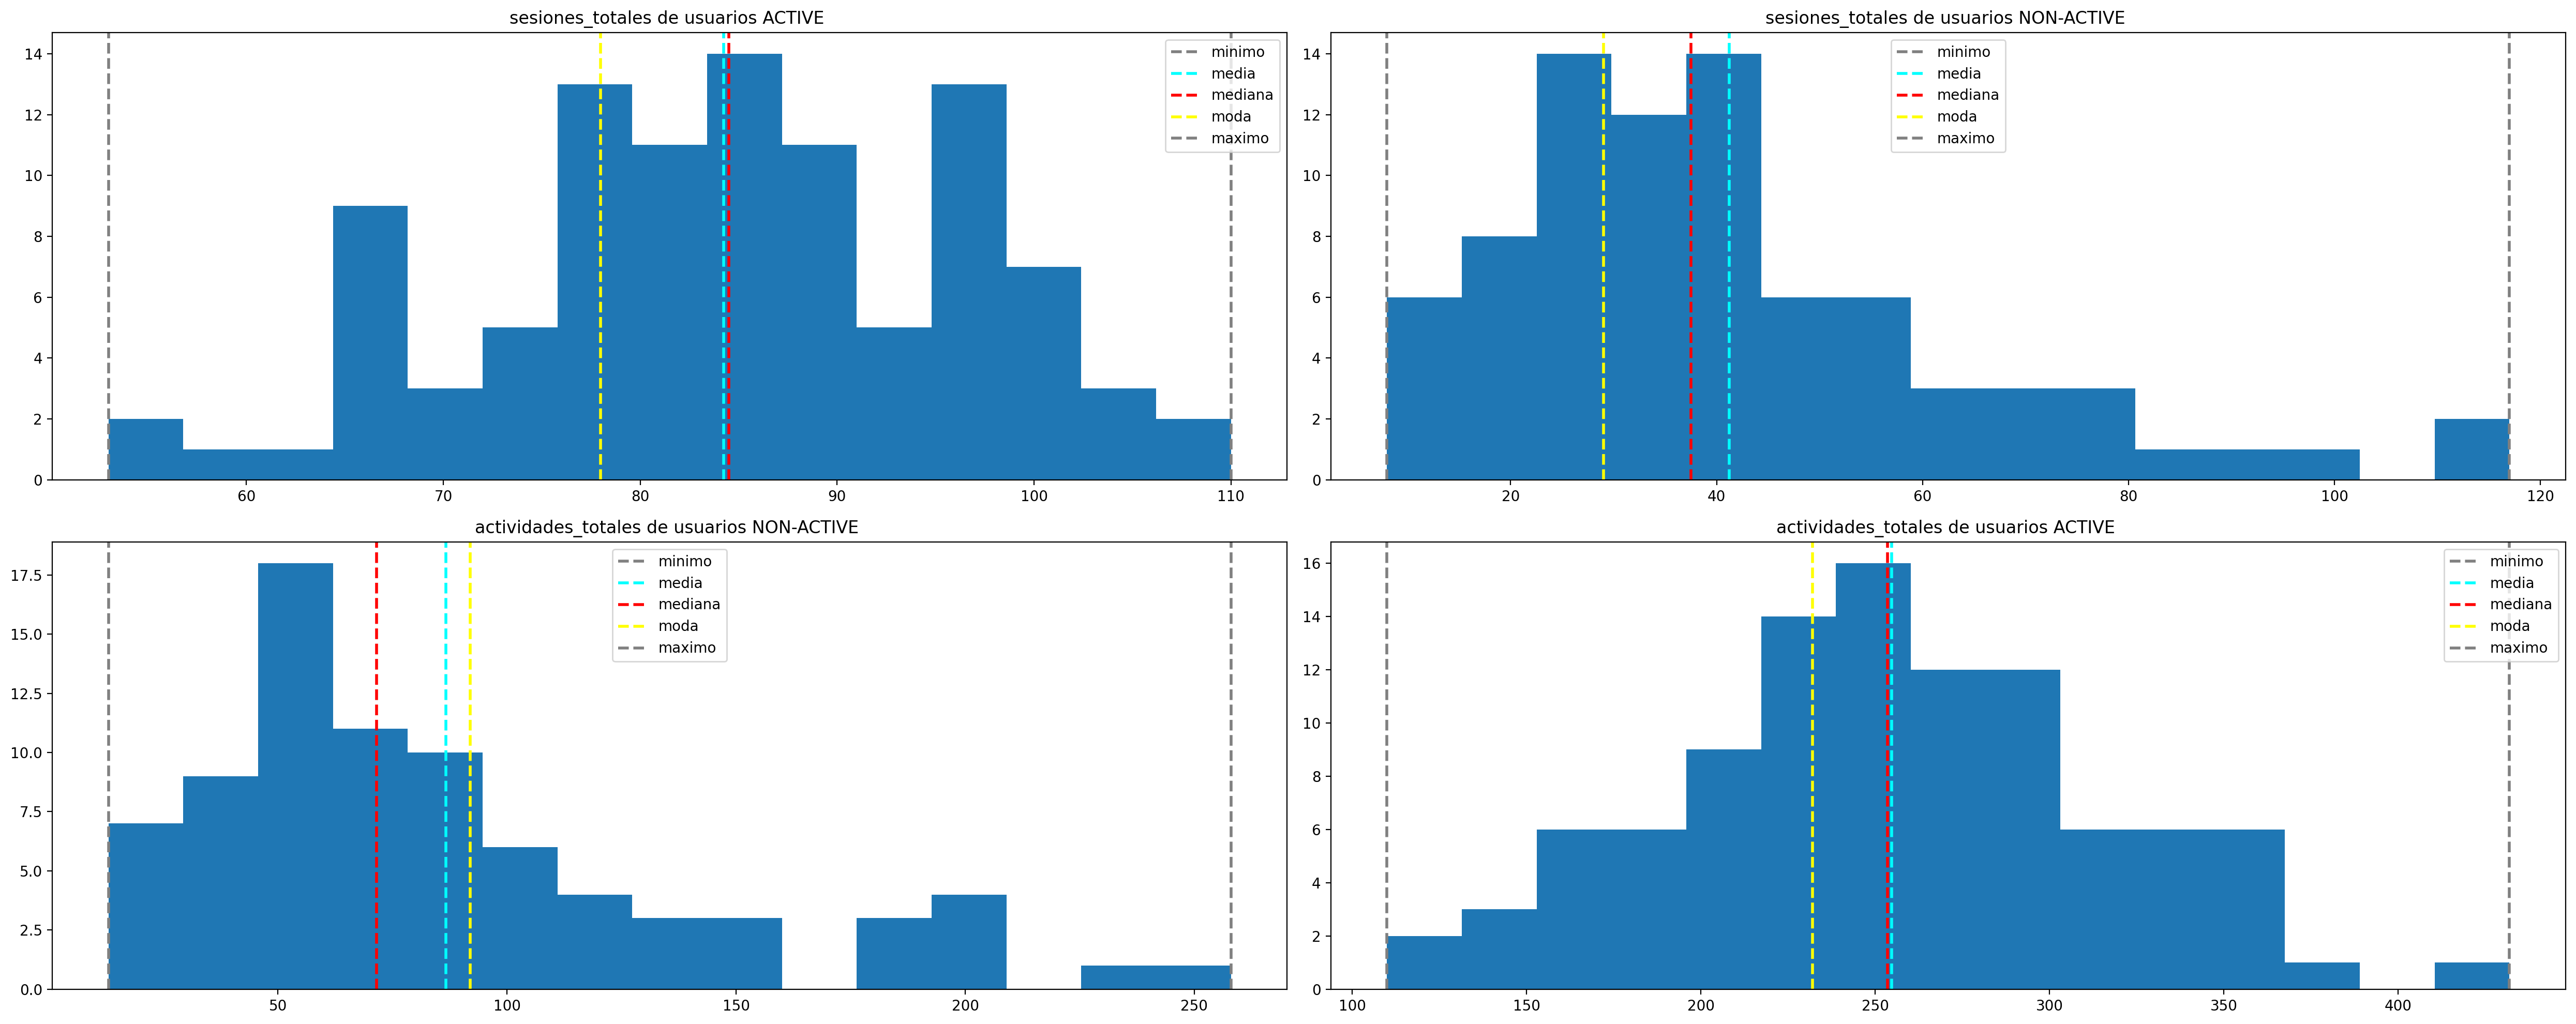

In [141]:
#generamos 4 graficos en 2 filas, para los atributos que calculamos anteriormente
fig, ax = plt.subplots(nrows=2,ncols=2,figsize = (25,10),dpi=200)
fig.tight_layout()

for i in range(0,2):
    min_active = reporte_marzo[reporte_marzo["class"]=="ACTIVE"].iloc[:,i+4].min()
    max_active = reporte_marzo[reporte_marzo["class"]=="ACTIVE"].iloc[:,i+4].max()
    media_active = reporte_marzo[reporte_marzo["class"]=="ACTIVE"].iloc[:,i+4].mean()
    mediana_active = reporte_marzo[reporte_marzo["class"]=="ACTIVE"].iloc[:,i+4].median()
    moda_active = reporte_marzo[reporte_marzo["class"]=="ACTIVE"].iloc[:,i+4].mode()[0]
    
    min_non = reporte_marzo[reporte_marzo["class"]=="NON-ACTIVE"].iloc[:,i+4].min()
    max_non = reporte_marzo[reporte_marzo["class"]=="NON-ACTIVE"].iloc[:,i+4].max()
    media_non = reporte_marzo[reporte_marzo["class"]=="NON-ACTIVE"].iloc[:,i+4].mean()
    mediana_non = reporte_marzo[reporte_marzo["class"]=="NON-ACTIVE"].iloc[:,i+4].median()
    moda_non = reporte_marzo[reporte_marzo["class"]=="NON-ACTIVE"].iloc[:,i+4].mode()[0]
    
    
    ax[(2*i//2)][(i)%2].hist(x=reporte_marzo[reporte_marzo["class"]=="ACTIVE"].iloc[:,i+4], bins=15)
    ax[(2*i//2)][(i)%2].set_title(reporte_marzo.columns[i+4] + " de usuarios ACTIVE ")
    ax[((2*i)//2)][(i+1)%2].hist(x=reporte_marzo[reporte_marzo["class"]=="NON-ACTIVE"].iloc[:,i+4], bins=15)
    ax[((2*i)//2)][(i+1)%2].set_title(reporte_marzo.columns[i+4] + " de usuarios NON-ACTIVE ")
    
    
    ax[((2*i)//2)][(i)%2].axvline(x=min_active, color = 'gray', linestyle='dashed', linewidth = 2,label="minimo")
    ax[((2*i)//2)][(i)%2].axvline(x=media_active, color = 'cyan', linestyle='dashed', linewidth = 2, label="media")
    ax[((2*i)//2)][(i)%2].axvline(x=mediana_active, color = 'red', linestyle='dashed', linewidth = 2,label="mediana")
    ax[((2*i)//2)][(i)%2].axvline(x=moda_active, color = 'yellow', linestyle='dashed', linewidth = 2, label="moda")
    ax[((2*i)//2)][(i)%2].axvline(x=max_active, color = 'gray', linestyle='dashed', linewidth = 2, label="maximo")
    
    ax[((2*i)//2)][(i+1)%2].axvline(x=min_non, color = 'gray', linestyle='dashed', linewidth = 2,label="minimo")
    ax[((2*i)//2)][(i+1)%2].axvline(x=media_non, color = 'cyan', linestyle='dashed', linewidth = 2, label="media")
    ax[((2*i)//2)][(i+1)%2].axvline(x=mediana_non, color = 'red', linestyle='dashed', linewidth = 2,label="mediana")
    ax[((2*i)//2)][(i+1)%2].axvline(x=moda_non, color = 'yellow', linestyle='dashed', linewidth = 2, label="moda")
    ax[((2*i)//2)][(i+1)%2].axvline(x=max_non, color = 'gray', linestyle='dashed', linewidth = 2, label="maximo")
    
    ax[((2*i)//2)][(i)%2].legend()
    ax[((2*i)//2)][(i+1)%2].legend()
    

fig.tight_layout()
plt.show